In [96]:
import logging
import os
import warnings
import pypsa
import yaml
import pandas as pd
import geopandas as gpd
import numpy as np
import scipy as sp
import networkx as nx
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.io.img_tiles import OSM
import cartopy.feature as cfeature

from scipy.sparse import csgraph
from itertools import product
import re

from shapely.geometry import Point, LineString
import shapely, shapely.prepared
from shapely.wkt import loads
from shapely.validation import make_valid

import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
warnings.filterwarnings('ignore')
logging.getLogger().setLevel(logging.WARNING)


In [97]:
red1 = '#891D2D'
red2 = '#BA3B31'
orange = '#F58221'
yellow = '#FCAF19'
brown = '#440A15'
purple1 = '#3B1053'
purple2 = '#76518E'
purple3 = '#B69DC7'
teal1 = '#032838'
teal2 = '#154655'
teal3 = '#527D77'
teal4 = '#8DB5AF'
green1 = '#294839'
green2 = '#6E966E'
green3 = '#A3BDA3'
beige1 = '#927F48'
beige2 = '#A89677'
beige3 = '#D2CDAD'

from matplotlib.colors import ListedColormap

In [98]:
# Helper functions

from os import path


def get_power_prod(year):
    path = 'C:/Users/noraky/Documents/Test_4/pypsa-earth/results_RC_10/RC_10_' + str(year) + '.nc'
    network = pypsa.Network(path)
    carrier_list = network.generators.carrier.unique()

    production_data = {}

    for carrier in carrier_list:
        total_production = network.generators_t.p.filter(like=carrier, axis=1).sum().sum() / 1000000  # Convert to TWh
        production_data[carrier] = total_production

    hydro_production = 0
    if 'hydro' in network.storage_units.carrier.unique():
        hydro_production += network.storage_units_t.p_dispatch.filter(like='hydro', axis=1).sum().sum() / 1000000  # Convert to TWh

    hydro_production += production_data.pop('ror', 0)
    production_data['hydro'] = hydro_production

    df = pd.DataFrame([production_data], index=[year])
    return df

def get_bus(bus_name, bus_info):
    if bus_name == bus_info['Bus']:
        return bus_info['x'], bus_info['y']

def get_demand(year):
    path = 'C:/Users/noraky/Documents/Test_4/pypsa-earth/results_RC_10/RC_10_' + year + '.nc'
    network = pypsa.Network(path)
    el_demand =network.loads_t.p_set
    regional_demand = pd.DataFrame(el_demand.sum()/1000000)
    return regional_demand.sum()

def total_production(year):
    prod = pd.DataFrame(get_power_prod(str(year)))
    prod.drop('load', axis=1, inplace=True)
    return prod.sum().sum()

def get_power_mix(year):
    total_prod = total_production(str(year))
    prod = get_power_prod(str(year))
    prod_series = prod.iloc[0].drop('load', errors='ignore')
    fractions = prod_series / total_prod

    df = pd.DataFrame(fractions).transpose()
    df.index = [year]
    return df

def get_max_output(year):
    path = 'C:/Users/noraky/Documents/Test_4/pypsa-earth/results_RC_10/RC_10_' + year + '.nc'
    network = pypsa.Network(path)
    return network.generators.groupby(by='carrier')["p_max_pu"].sum()

def custom_autopct(pct):
    return ('%1.1f%%' % pct) if pct > 0 else ''

def get_total_cost(year):
    path = 'C:/Users/noraky/Documents/Test_4/pypsa-earth/results_RC_10/RC_10_' + year + '.nc'
    network = pypsa.Network(path)
    return network.objective

def get_emissions(year):
    path = 'C:/Users/noraky/Documents/Test_4/pypsa-earth/results_RC_10/RC_10_' + year + '.nc'
    network = pypsa.Network(path)
    emissions = network.generators_t.p / network.generators.efficiency * network.generators.carrier.map(network.carriers.co2_emissions)
    return emissions.sum().sum() / 1000000

def get_installed_capacity(year):
    path = 'C:/Users/noraky/Documents/Test_4/pypsa-earth/results_RC_10/RC_10_' + year + '.nc'
    network = pypsa.Network(path)

    capacities = network.generators.groupby(by='carrier')['p_nom'].sum()

    if 'ror' in capacities:
        capacities['hydro'] = capacities.get('hydro', 0) + capacities.pop('ror')

    if 'hydro' in network.storage_units.carrier.unique():
        hydro_capacity = network.storage_units[network.storage_units.carrier == 'hydro']['p_nom'].sum()
        capacities['hydro'] += hydro_capacity

    capacities.pop('load')
    capacities_df = capacities.to_frame().transpose()
    capacities_df.index = [year]

    return capacities_df

def get_snapshot_generation(year, first_date, second_date, carrier):
    path = 'C:/Users/noraky/Documents/Test_4/pypsa-earth/results_RC_10/RC_10_' + year + '.nc'
    network = pypsa.Network(path)
    if carrier == 'hydro':
        generation = network.storage_units_t.p_dispatch[first_date:second_date].sum(axis=1)
    else:
        generation = network.generators_t.p.loc[first_date:second_date].groupby(network.generators.carrier, axis=1).sum()[carrier]
    return generation

def get_snapshot_demand(year, first_date, second_date):
    path = 'C:/Users/noraky/Documents/Test_4/pypsa-earth/results_RC_10/RC_10_' + year + '.nc'
    network = pypsa.Network(path)
    demand = network.loads_t.p_set.loc[first_date:second_date].sum(axis=1)*-1
    return demand

In [99]:
print(get_installed_capacity(str(2035)))
print(get_power_prod(str(2035)))
colors = [teal2,yellow, beige1, green2, beige2, red1, teal4]

carrier        CCGT        OCGT    biomass        oil     onwind        solar  \
2035     1364.00001  948.955322  55.584257  11.741736  26.569197  1893.802102   

carrier  hydro  
2035     732.2  
        onwind     solar     CCGT   biomass      OCGT       oil      load  \
2035  0.002145  3.605764  6.06477  0.436578  0.093822  0.000064  0.017602   

         hydro  
2035  6.406003  


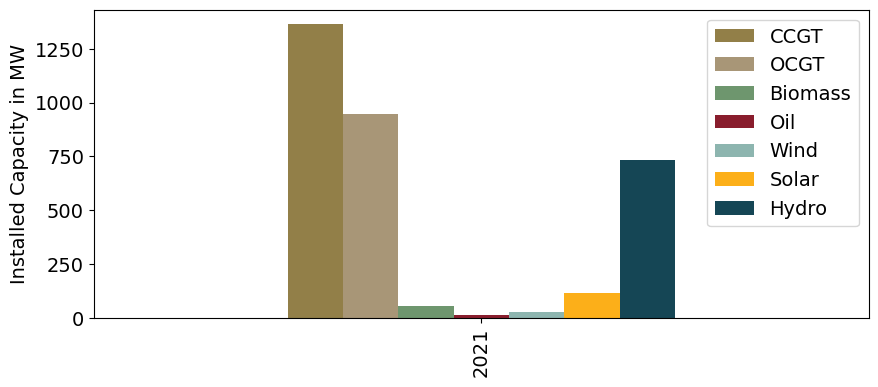

In [100]:
installed_capacity = get_installed_capacity(str(2021))
colors_cap = [beige1, beige2, green2, red1, teal4, yellow, teal2]
names = ['CCGT',    'OCGT',  'Biomass',   'Oil',  'Wind',  'Solar'  ,'Hydro']
installed_capacity.columns = names
installed_capacity.plot(kind='bar',color=colors_cap,figsize=(10, 4), legend=True)

plt.ylabel('Installed Capacity in MW')
plt.show()

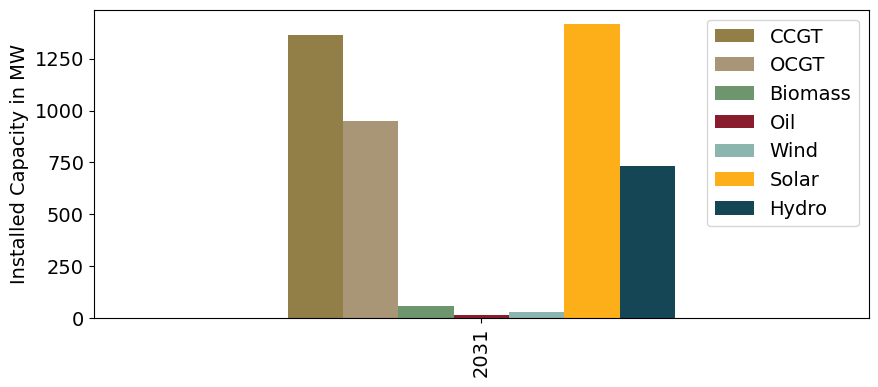

In [101]:
installed_capacity = get_installed_capacity(str(2031))
names = ['CCGT',    'OCGT',  'Biomass',   'Oil',  'Wind',  'Solar'  ,'Hydro']
installed_capacity.columns = names
colors = [teal4,yellow, beige1, green2, beige2, beige3, teal2]
installed_capacity.plot(kind='bar',color=colors_cap,figsize=(10, 4), legend=True)

plt.ylabel('Installed Capacity in MW')
plt.show()

        onwind     solar      CCGT   biomass      OCGT           oil     hydro
2021  0.002151  1.126654  1.483894  0.429207  0.000004  1.188072e-07  6.413175
2022  0.002124  1.257481  1.727823  0.428723  0.000005  1.446302e-07  6.412933
2023  0.002118  1.385896  1.968660  0.428593  0.000004  1.294783e-07  6.411821
2024  0.002096  1.491955  2.168730  0.428230  0.000004  1.404609e-07  6.413079
2025  0.002057  1.599298  2.369347  0.427858  0.000005  1.551333e-07  6.413532
2026  0.002099  1.795976  2.736923  0.428376  0.000005  1.279372e-07  6.409724
2027  0.002118  1.974599  3.067522  0.428626  0.000008  2.008943e-07  6.406237
2028  0.002094  2.158292  3.411843  0.428400  0.000006  1.774974e-07  6.406480
2029  0.002124  2.348062  3.772394  0.428280  0.000006  1.947261e-07  6.408253
2030  0.002126  2.547250  4.148897  0.430688  0.000327  2.475616e-07  6.405839
2031  0.002147  2.754379  4.536109  0.431710  0.005712  2.745358e-07  6.407074
2032  0.002153  2.968818  4.944026  0.435522  0.0077

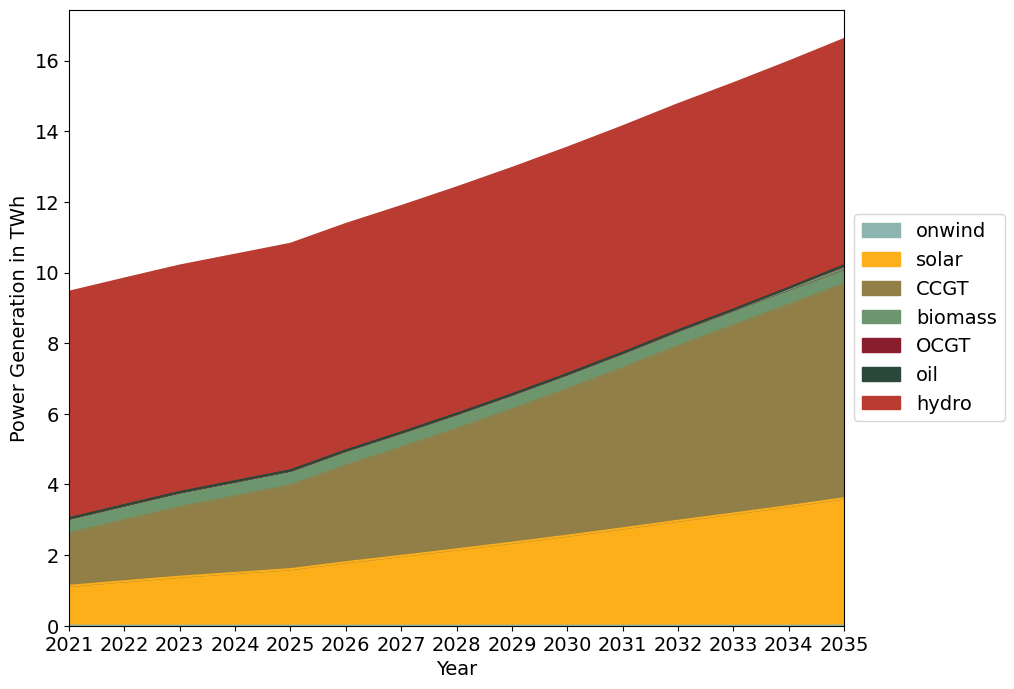

In [115]:
years = [2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035]
production_sources = [get_power_prod(str(year)) for year in years]
production = pd.concat(production_sources)
if 'load' in production:
  production.drop('load', axis=1, inplace=True)
print(production)
#names = ['Wind', 'Solar', 'CCGT', 'Biomass', 'OCGT', 'Oil', 'Hydro']
#production.columns = names

#colors = [color_for_wind, color_for_solar, color_for_ccgt, color_for_biomass, color_for_ocgt, color_for_oil, color_for_hydro]
colors = [teal4,yellow, beige1, green2, red1, green1, red2, teal2]

production.plot.area(stacked=True, color=colors,figsize=(10, 8))

plt.ylabel('Power Generation in TWh')
plt.xlabel('Year')
plt.xlim(0,14)
plt.xticks(range(len(years)), years)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

        onwind     solar      CCGT   biomass          OCGT           oil  \
2021  0.000227  0.119159  0.156941  0.045394  4.455659e-07  1.256543e-08   

         hydro  
2021  0.678278  


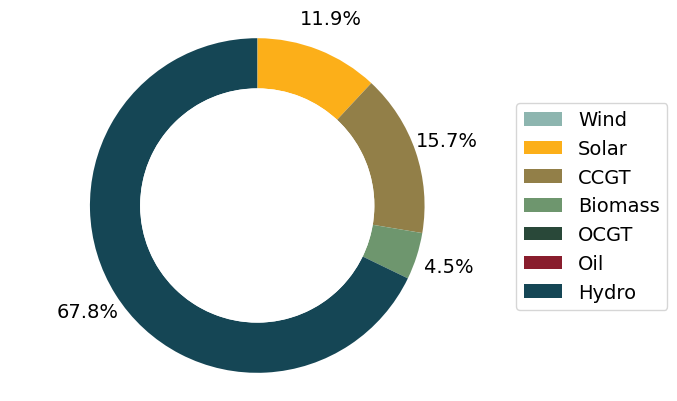

In [103]:
power_mix_df = get_power_mix(2021)
print(power_mix_df)
plt.rcParams['font.size'] = 14

names = ['Wind', 'Solar', 'CCGT', 'Biomass', 'OCGT', 'Oil', 'Hydro']
power_mix_df.columns = names

fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(power_mix_df.iloc[0].values, autopct=custom_autopct, colors=colors, startangle=90, counterclock=False, wedgeprops=dict(width=0.3), pctdistance=1.2)

# Hide the zero-value autotexts
for autotext in autotexts:
    if autotext.get_text() == '0.0%':
        autotext.set_visible(False)

ax.axis('equal')
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)


plt.legend(names, loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

        onwind     solar      CCGT   biomass      OCGT       oil     hydro
2035  0.000129  0.217095  0.365146  0.026285  0.005649  0.000004  0.385691


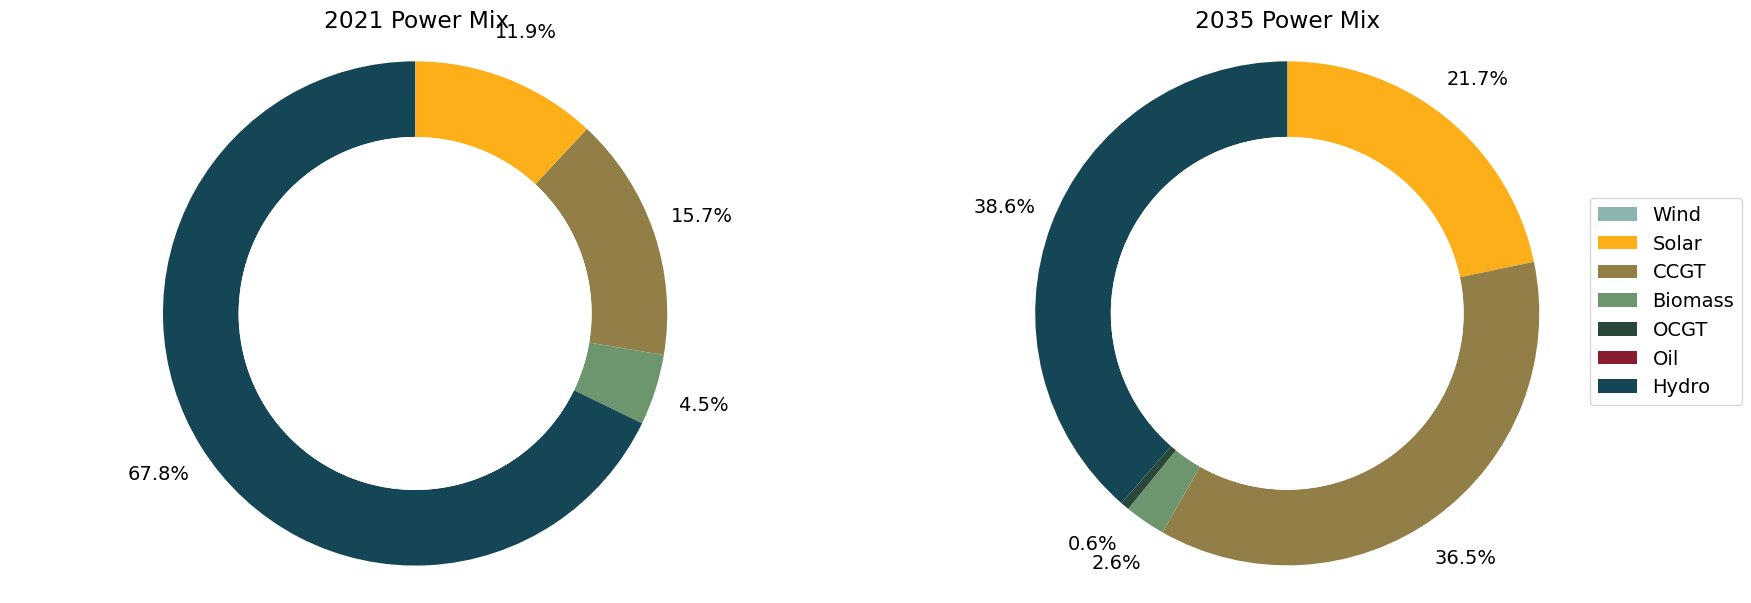

In [104]:
power_mix_21 = get_power_mix(2021)
power_mix_35 = get_power_mix(2035)
print(power_mix_35)

plt.rcParams['font.size'] = 14

names = ['Wind', 'Solar', 'CCGT', 'Biomass', 'OCGT', 'Oil', 'Hydro']
power_mix_21.columns = names
power_mix_35.columns = names

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

wedges1, texts1, autotexts1 = ax1.pie(
    power_mix_21.iloc[0].values, autopct=custom_autopct,
    colors=colors, startangle=90, counterclock=False, 
    wedgeprops=dict(width=0.3), pctdistance=1.2
)

wedges2, texts2, autotexts2 = ax2.pie(
    power_mix_35.iloc[0].values, autopct=custom_autopct,
    colors=colors, startangle=90, counterclock=False, 
    wedgeprops=dict(width=0.3), pctdistance=1.2
)

for autotext in autotexts1 + autotexts2:
    if autotext.get_text() == '0.0%':
        autotext.set_visible(False)

centre_circle1 = plt.Circle((0,0),0.70,fc='white')
ax1.add_artist(centre_circle1)
ax1.set_title('2021 Power Mix')

centre_circle2 = plt.Circle((0,0),0.70,fc='white')
ax2.add_artist(centre_circle2)
ax2.set_title('2035 Power Mix')

ax1.axis('equal')
ax2.axis('equal')

fig.legend(names, loc="center right", bbox_to_anchor=(1, 0.5))

plt.tight_layout(pad=3.0)
plt.show()

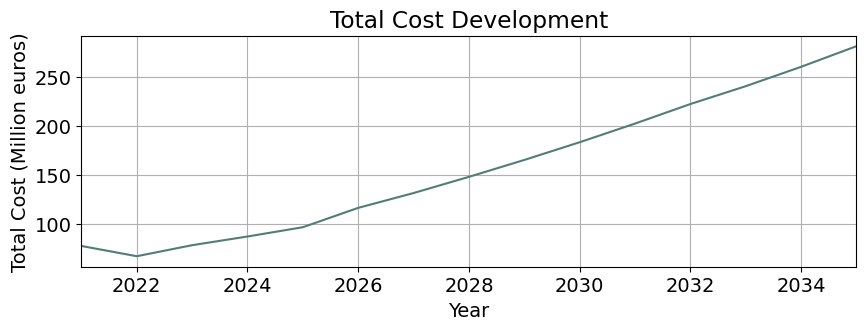

In [105]:
total_costs = [get_total_cost(str(year))/10**6 for year in years]
plt.figure(figsize=(10, 3))
plt.plot(years, total_costs, color=teal3)
plt.title('Total Cost Development')
plt.xlabel('Year')
plt.ylabel('Total Cost (Million euros)')
plt.xlim(2021,2035)
plt.grid(zorder = 0)
plt.show()

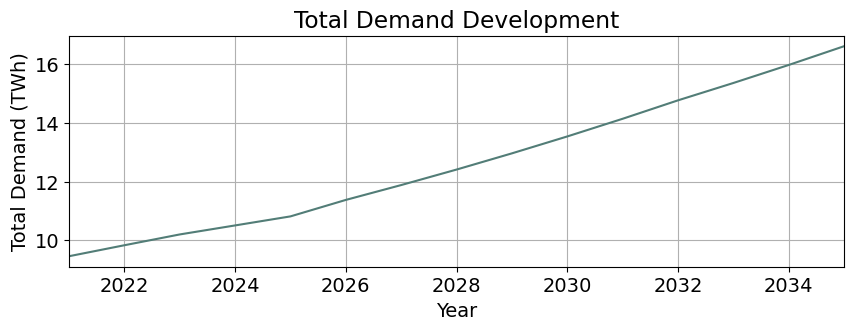

In [106]:
total_demand = [get_demand(str(year)) for year in years]
plt.figure(figsize=(10, 3))
plt.plot(years, total_demand, color=teal3)
plt.title('Total Demand Development')
plt.xlabel('Year')
plt.ylabel('Total Demand (TWh)')
plt.xlim(2021,2035)
plt.grid(zorder = 0)
plt.show()

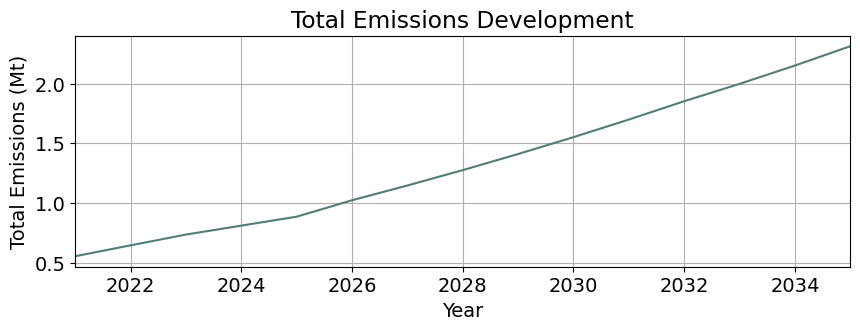

In [107]:
total_emissions = [get_emissions(str(year)) for year in years]
plt.figure(figsize=(10, 3))
plt.plot(years, total_emissions, color=teal3)
plt.title('Total Emissions Development')
plt.xlabel('Year')
plt.ylabel('Total Emissions (Mt)')
plt.xlim(2021,2035)
plt.grid(zorder = 0)
plt.show()

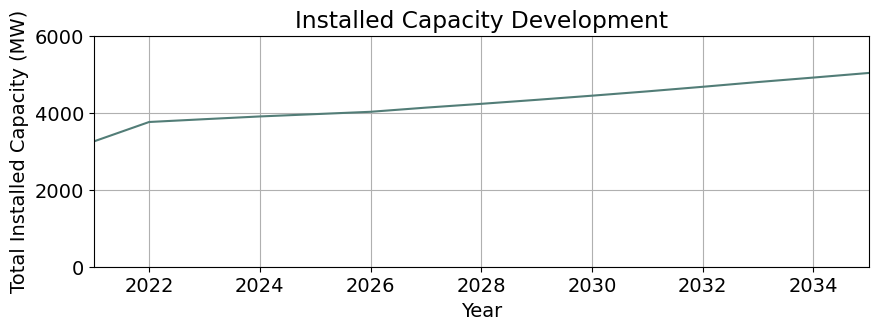

In [108]:
total_capacity = [get_installed_capacity(str(year)).sum().sum() for year in years]
plt.figure(figsize=(10, 3))
plt.plot(years, total_capacity, color=teal3)
plt.title('Installed Capacity Development')
plt.xlabel('Year')
plt.ylabel('Total Installed Capacity (MW)')
plt.xlim(2021,2035)
plt.ylim(0,6000)
plt.grid(zorder = 0)
plt.show()

Oil:  0.006528813264875142
Biomass:  9252.772167306477


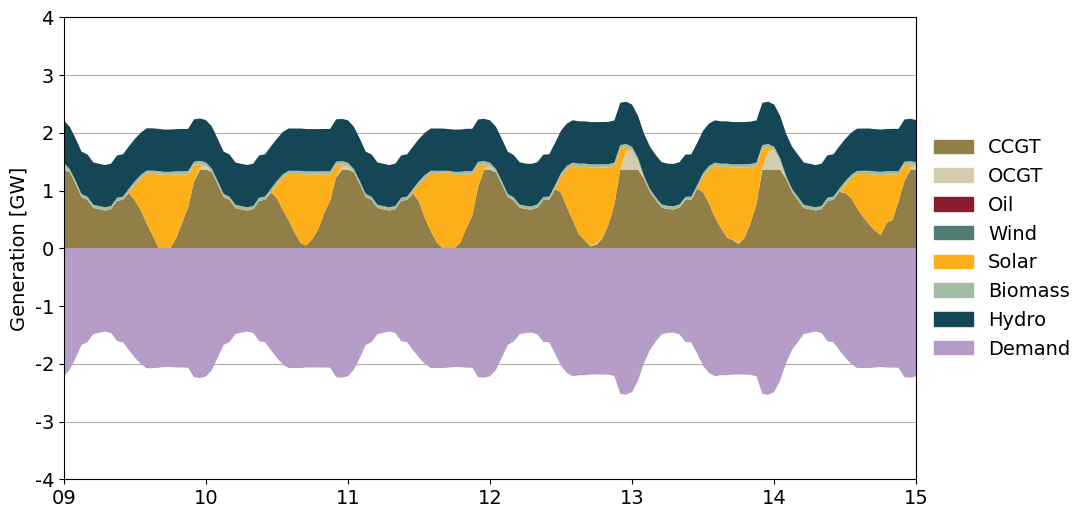

In [109]:
first_date = "2013-01-09"
second_date = "2013-01-15"
year = '2035'

CCGT = get_snapshot_generation(year, first_date, second_date, 'CCGT')
OCGT = get_snapshot_generation(year, first_date, second_date, 'OCGT')
Oil = get_snapshot_generation(year, first_date, second_date, 'oil')
Wind = get_snapshot_generation(year, first_date, second_date, 'onwind')
Solar = get_snapshot_generation(year, first_date, second_date, 'solar')
Biomass = get_snapshot_generation(year, first_date, second_date, 'biomass')
Hydro = get_snapshot_generation(year, first_date, second_date, 'ror')
Hydro += get_snapshot_generation(year, first_date, second_date, 'hydro')
demand = get_snapshot_demand(year, first_date, second_date)   

print('Oil: ', Oil.sum())
print('Biomass: ', Biomass.sum())

fig, ax=plt.subplots(figsize = (11,6))
A = plt.stackplot(CCGT.index,CCGT,OCGT,Oil, Wind, Solar, Biomass, Hydro, #,pbattery
                  colors=[beige1,beige3,red1,teal3,yellow,green3,teal2], zorder = 2) #,   purple3
plt.stackplot(CCGT.index,demand, colors=[purple3], zorder = 2) #,nbattery
plt.xticks(rotation = 0)
plt.yticks()
scale_y = 1e3
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
myFmt = mdates.DateFormatter('%d')
ax.xaxis.set_major_formatter(myFmt)
ax.set_ylabel('Generation [GW]')

start_date = pd.to_datetime(first_date)
end_date = pd.to_datetime(second_date)

ax.set_xlim(start_date, end_date)
ax.set_ylim(-4000, 4000)

CCGT_patch = mpatches.Patch(color=beige1, label ='CCGT')
OCGT_patch = mpatches.Patch(color=beige3, label ='OCGT')
oil_patch = mpatches.Patch(color = red1, label = 'Oil')
wind_patch = mpatches.Patch(color=teal3, label ='Wind')
solar_patch = mpatches.Patch(color=yellow, label ='Solar')
biomass_patch = mpatches.Patch(color = green3, label = 'Biomass')
hydro_patch = mpatches.Patch(color = teal2, label = 'Hydro')
load_patch = mpatches.Patch(color=purple3, label ='Demand')
handles=[CCGT_patch,OCGT_patch,oil_patch, wind_patch, solar_patch, biomass_patch, hydro_patch, load_patch]
ax.legend(handles=handles, frameon = False, loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(axis='y', zorder=0)